# Sætter partier og regioner ind i G og rewriter filen

In [33]:
import networkx as nx
import pickle
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import re
from fa2 import ForceAtlas2


In [34]:
data=pd.read_csv("danish_politkere_twitter2.csv")

In [35]:
data.groupby('Party').count()

,Names,Twittername,Region
Party,,,
Alternativet,4,4,4
Dansk Folkeparti,21,21,21
Det Konservative Folkeparti,22,22,22
Det Radikale Venstre,1,1,1
Enhedslisten,23,23,23
Government,14,14,14
Inuit Ataqatigiit,1,1,1
Liberal Alliance,7,7,7
Nye Borgerlige,4,4,4


In [36]:
len(data.index)

651

In [37]:
G = nx.read_gpickle("second_network_w_weights_listversion_wrealnames_v2.gpickle")

In [38]:
G.number_of_nodes()

561

In [39]:
def pre_check():
    nodes = G.nodes()
    count=0
    to_remove = [] 
    for node in nodes:
        if node in data.values:
            count+=1
        else:
            print(node + " will be removed")
            to_remove.append(node)
    for node in to_remove:
        G.remove_node(node)
    return len(to_remove)

print("Removing " +str(pre_check()) + " nodes")

Birgitte2012 will be removed
MFVMin will be removed
SassLarsen will be removed
AsgerChristens2 will be removed
Martin_geertsen will be removed
Removing 5 nodes


In [40]:
G.number_of_nodes()

556

In [41]:
dict_of_attributes = {}
for node in G.nodes():
    #print(node)
    x = data.loc[data['Twittername'] == node]
    #print(x)
    party =  x.values[0][2]
    region = x.values[0][3]
    #print(node, party, region)
    attribute = {'party': party, 'region': region}
    dict_of_attributes[node] = attribute
nx.set_node_attributes(G, dict_of_attributes)

 ## Yikes on amount of unknowns
Some googles show a lot of "Byråd / kommunalbestyrelsen"

# Count links betweeen parties

## with unknowns

In [42]:
parties = list(nx.get_node_attributes(G,'party').values())
#G.nodes(data=True)

In [43]:
politicians=list(G.nodes)
unique_parties = set(parties)

In [44]:
tweet_to_count = {}
tweet_out_count = {}


for party in unique_parties:
    tweet_to_count[party] = 0
    tweet_out_count[party] = 0


In [45]:
#print(parties)

In [46]:
# party in + out degrees
print("edges (mentions): " + str(G.number_of_edges()))
for edge in G.edges():
    _from = edge[0]
    _to = edge[1]
    _to_party = parties[politicians.index(_to)]
    _out_party = parties[politicians.index(_from)]
    
    
    tweet_to_count[_to_party] += 1
    tweet_out_count[_out_party] += 1

    
tweet_to_count = dict(sorted(tweet_to_count.items(), key=lambda item: item[1], reverse=True))
tweet_out_count = dict(sorted(tweet_out_count.items(), key=lambda item: item[1],reverse=True))


edges (mentions): 10263


# Visualizations

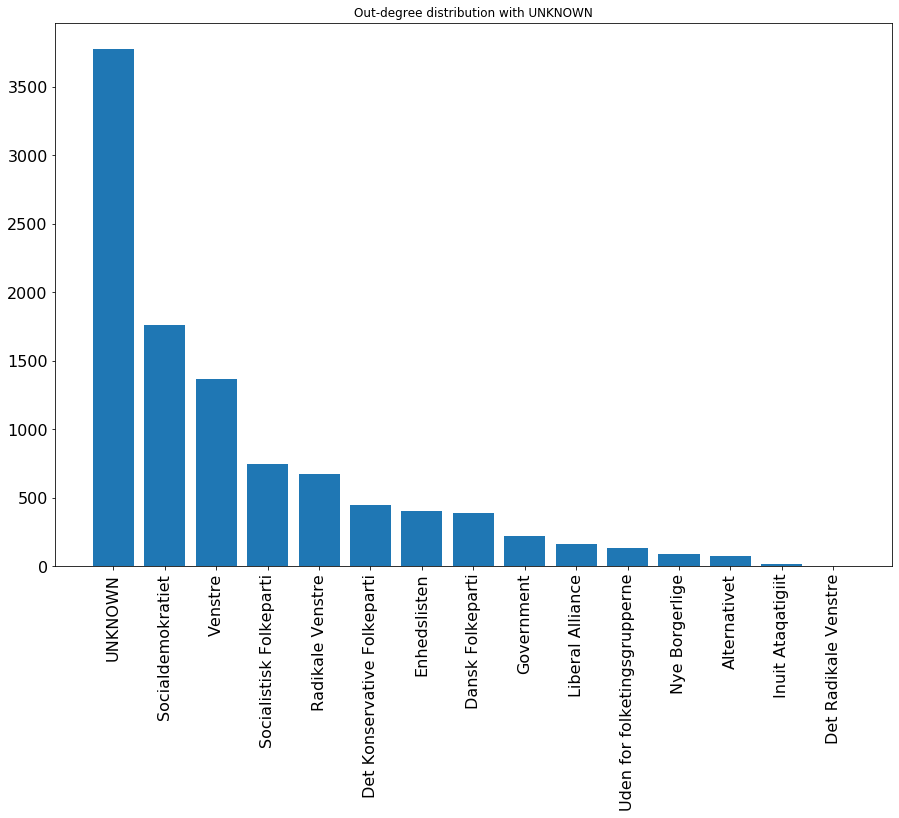

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.subplots(figsize=(15,10))

plt.tick_params(labelsize=16)
plt.xticks(rotation=90)
plt.bar(tweet_out_count.keys(), tweet_out_count.values())
plt.title("Out-degree distribution with UNKNOWN")
plt.show()

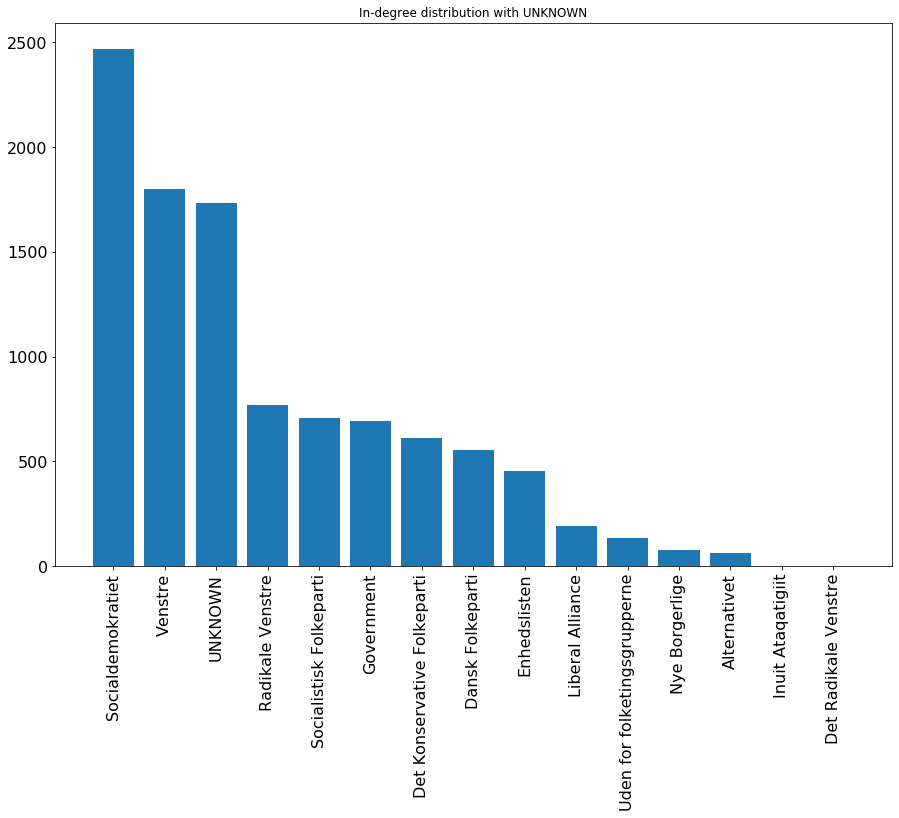

In [48]:
fig = plt.subplots(figsize=(15,10))

plt.tick_params(labelsize=16)
plt.xticks(rotation=90)
plt.bar(tweet_to_count.keys(), tweet_to_count.values())
plt.title("In-degree distribution with UNKNOWN")

plt.show()

## Without unknowns

In [49]:

tweet_to_count_clean = tweet_to_count.copy()
tweet_out_count_clean = tweet_out_count.copy()

tweet_to_count_clean.pop('UNKNOWN')
tweet_out_count_clean.pop('UNKNOWN')


3778

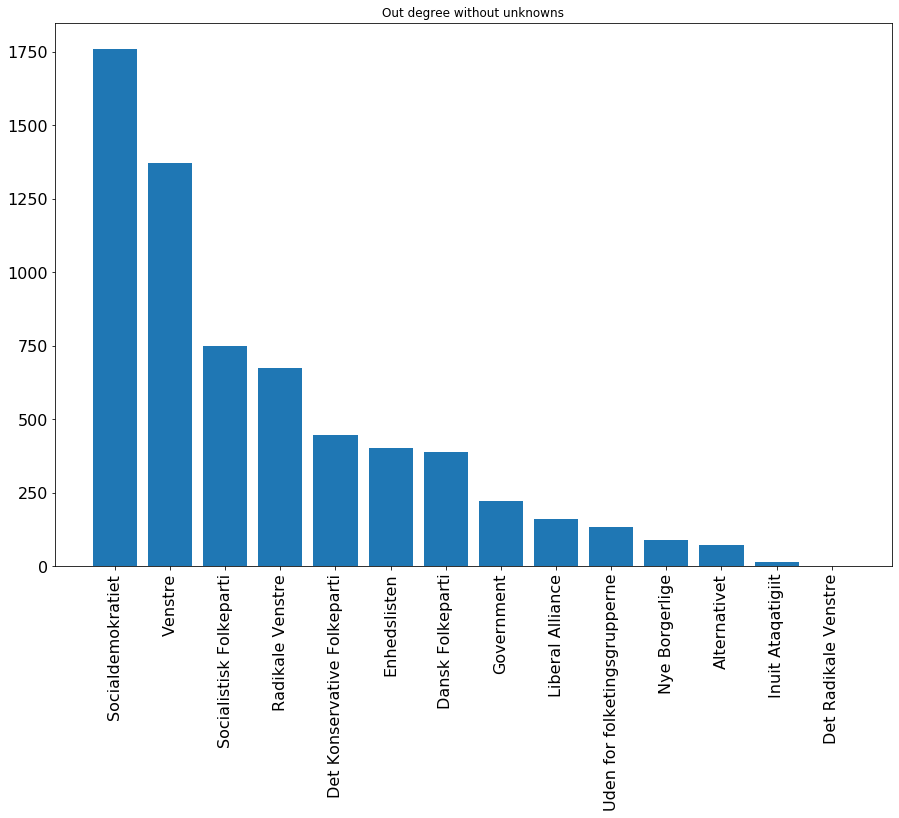

In [50]:
fig = plt.subplots(figsize=(15,10))

plt.tick_params(labelsize=16)
plt.xticks(rotation=90)
plt.bar(tweet_out_count_clean.keys(), tweet_out_count_clean.values())
plt.title("Out degree without unknowns")
plt.show()


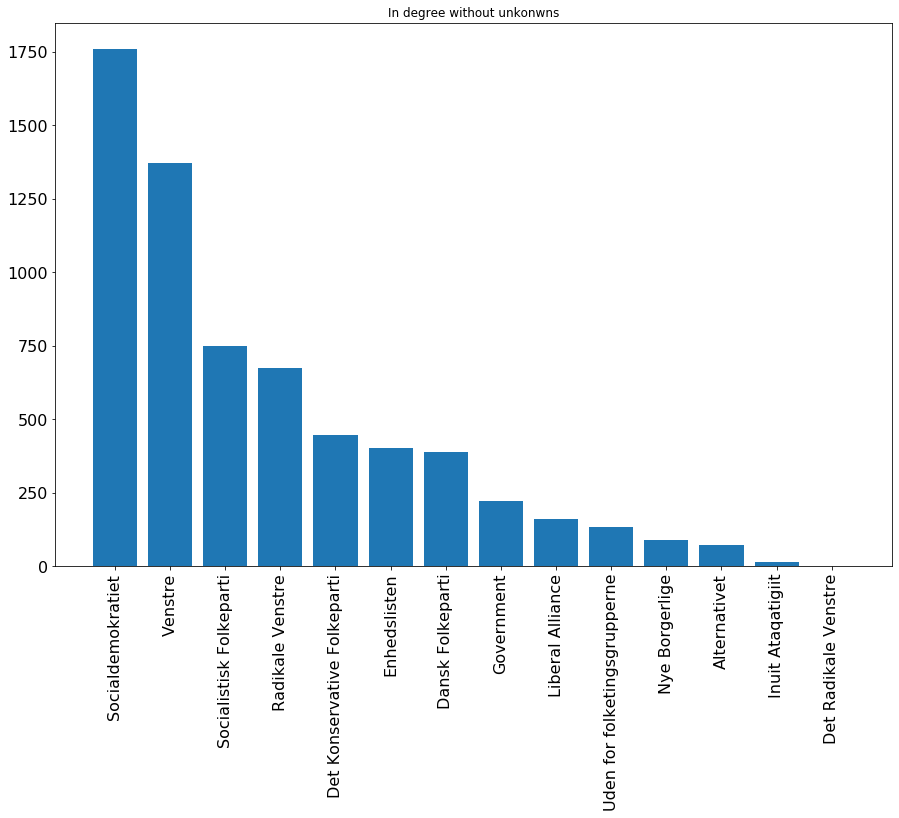

In [51]:

fig = plt.subplots(figsize=(15,10))

plt.tick_params(labelsize=16)
plt.xticks(rotation=90)
plt.bar(tweet_out_count_clean.keys(), tweet_out_count_clean.values())
plt.title("In degree without unkonwns")
plt.show()

## Getting average as the amount of policians isn't at all evenly distributed

In [52]:
vals = nx.get_node_attributes(G, "party").values()
sum_party =dict.fromkeys(tweet_out_count.keys(),0)
for party_occ in vals:
    sum_party[party_occ] += 1
sum_party

avg_tweet_out = dict.fromkeys(tweet_out_count.keys())
avg_tweet_in= dict.fromkeys(tweet_to_count.keys())

for key in tweet_out_count:
    avg_tweet_out[key] = tweet_out_count[key] / sum_party[key]
    avg_tweet_in[key] = tweet_to_count[key] / sum_party[key]
    
ang_tweet_out = dict(sorted(avg_tweet_out.items(), key=lambda item: item[1],reverse=True))
avg_tweet_in = dict(sorted(avg_tweet_in.items(), key=lambda item: item[1],reverse=True))


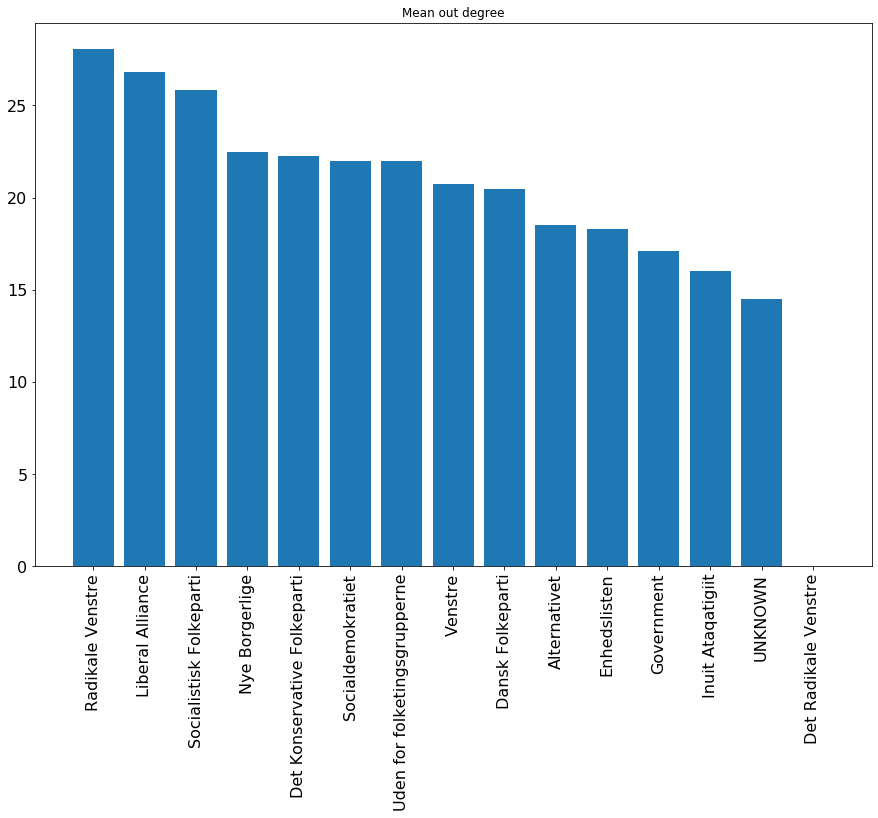

In [53]:
#ax = plt.subplot(111)

#x = pd.DataFrame([avg_tweet_in])
#chart =sns.barplot(x="day", y="total_bill",data=x)
#chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
#plt.show()
fig = plt.subplots(figsize=(15,10))

plt.tick_params(labelsize=16)
plt.xticks(rotation=90)
plt.bar(ang_tweet_out.keys(), ang_tweet_out.values())
plt.title("Mean out degree")
plt.show()

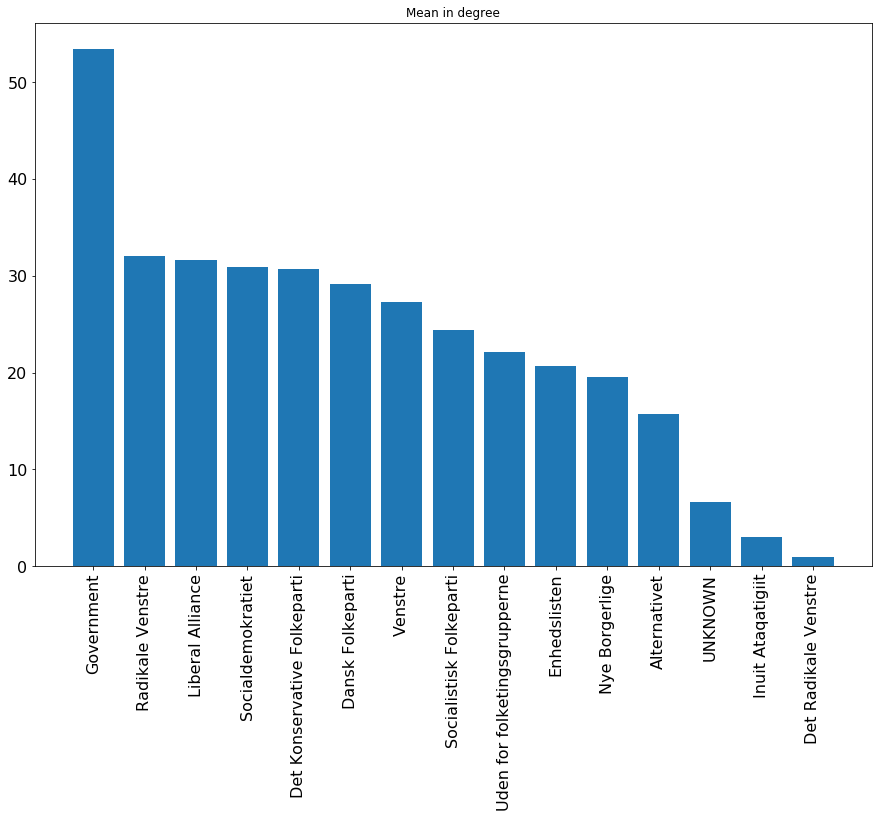

In [54]:
fig = plt.subplots(figsize=(15,10))

plt.tick_params(labelsize=16)
plt.xticks(rotation=90)
plt.bar(avg_tweet_in.keys(), avg_tweet_in.values())
plt.title("Mean in degree")
plt.show()

## Graph visualization

In [55]:
Gcc = sorted(nx.weakly_connected_components(G), key=len, reverse=True)

giant = G.subgraph(Gcc[0])
giant = giant.to_undirected()



for node in list(giant.nodes()):
    if (giant.degree(node) <= 2):
        giant.remove_node(node)

parties = list(nx.get_node_attributes(giant,'party').values())
color_map = []
d = dict(giant.degree) #degrees for every node

#Making color list
for i in range(len(parties)): #for all nodes
    if parties[i] == 'Socialdemokratiet':
        color_map.append('red')
    elif parties[i] == 'Venstre':
        color_map.append('blue')
        
    elif parties[i]=='Dansk Folkeparti':
        color_map.append('pink')
        
    elif parties[i]=='Socialistisk Folkeparti':
        color_map.append('brown')
        
    elif parties[i] == 'Radikale Venstre':
        color_map.append('#1f78b4')
        
    elif parties[i] == 'Enhedslisten':
        color_map.append('#D0004D')
        
    elif parties[i] == 'Det Konservative Folkeparti':
        color_map.append('#00583C')
        
    elif parties[i] == 'Nye Borgerlige':
        color_map.append('#235d66')
    elif parties[i] == 'Liberal Alliance':
        color_map.append('orange')
    elif parties[i] == 'Alternativet':
        color_map.append('yellow')
    elif parties[i] == 'Government':
        color_map.append('black')
    else:
        color_map.append('white')

100%|██████████| 2000/2000 [00:21<00:00, 95.17it/s] 


BarnesHut Approximation  took  2.29  seconds
Repulsion forces  took  17.73  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  0.23  seconds
AdjustSpeedAndApplyForces step  took  0.37  seconds


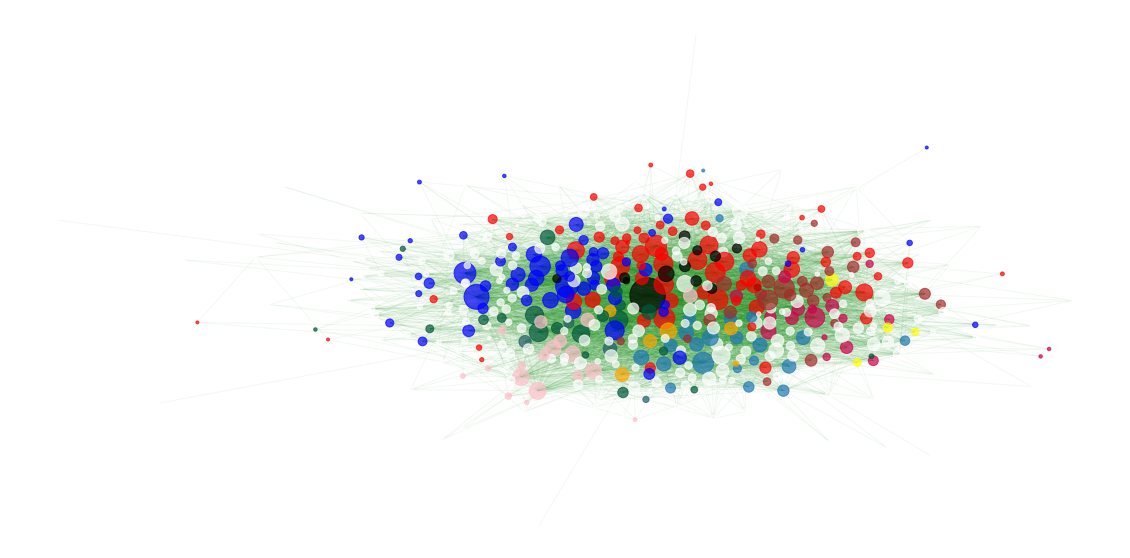

In [56]:
from fa2 import ForceAtlas2

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs   #Want hubs inside other!
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=True,
                        gravity=1.0,

                        # Log
                        verbose=True)


positions = forceatlas2.forceatlas2_networkx_layout(giant, pos=None, iterations=2000)

plt.figure(figsize=(20,10))
nx.draw_networkx_nodes(giant, positions, node_color=color_map, alpha=0.7,node_size=[v * 3 for v in d.values()])
nx.draw_networkx_edges(giant, positions, edge_color="green", alpha=0.05)
plt.axis('off')
plt.show()

## Observations
The graph is quite compact, with many large blue and red nodes which makes sense, as these are the biggest parties in denmark; namely "Venstre" and "Socialdemokratiet". Furthermore, there are large black nodes that are central in the network - this also makes sense as we've marked government entities as black. However there are still some problems with the visualization that we want to solve.


# Segregating into red block vs blue block

The problem with the network visualization is that we have too many different parties and getting a nice visualization becomes difficult. Bloc politics refers to the act of parties uniting in order to gain a majority vote over the parliament. In danish politics, according to https://da.wikipedia.org/wiki/Blokpolitik we have 3 blocs, red blue and green. We will segregate our parties into this by adding a graph attribute "bloc" .

In [57]:
red_bloc = ['Socialdemokratiet', 'Enhedslisten', 'Socialistisk Folkeparti', 'Radikale Venstre']
blue_bloc = ['Venstre', 'Dansk Folkeparty', 'Det Konservative Folkeparti', 'Liberal Alliance', 'Nye Borgerlige', 'Fremad']
green_bloc = ['Alternativet']
    
    
for key, val in dict_of_attributes.items():
    print(key)
    if val['party'] in red_bloc:
        val['block'] = 'red'
    elif val['party'] in blue_bloc:
        val['block'] = 'blue'
    elif val['party'] in green_bloc:
        val['block'] = 'green'
    elif val['party'] == 'Government':
        val['block'] = 'black'
    else: 
        val['block'] = 'white' # white node means unknown
        
nx.set_node_attributes(G, dict_of_attributes)

Gcc = sorted(nx.weakly_connected_components(G), key=len, reverse=True)

giant = G.subgraph(Gcc[0])
giant = giant.to_undirected()
d = dict(giant.degree) #degrees for every node

for node in list(giant.nodes()):
    if (giant.degree(node) <= 2):
        giant.remove_node(node)

block_color_map = list(nx.get_node_attributes(giant, 'block').values())
print(block_color_map)

vestager
SchaldemoseMEP
karmel80
oestergaard
sofiecn
simonkollerup
jesper_bedreby
RohlChristopher
larsloekke
Statsmin
_MaiMercado
JakobEllemann
SorenPape
RasmusJarlov
BjBrandenborg
Kristianthdahl
Jesper_Pet
rasmusnordqvist
FrankJensenKBH
LouiseElholm
JanEJoergensen
RStoklund
regeringDK
LotteRod
aahlers
PiaOlsen
signe_munk
PSkipperEL
MaiVilladsen
rubenkidde
DanJoergensen
NWammen
FrkCallesen
SamiraNawa
a_steenberg
stinuslindgreen
karinFbach
KatrineRobsoe
martinlidegaard
metteabildgaard
olebirkolesen
Hans_Kr_Skibby
LeaWermelin
mortenhelveg
Joymogensen
SandKjaer
orlaosterby
Sten_Knuth
BirgitteBergman
brittbager
zeniastampe
JeppeBruus
mattiastesfaye
RosenkrantzT
KHegaard
krarup_lars
Pia_Kjaersgaard
pederhvelplund
MogensJensenS
RosaLundEl
EvaFlyvholm
JakobSoelvhoej
AndersKronborg
nvillumsen
StemLAURITZEN
mfMorten
RuneLundEL
Heunicke
karinaehl
Danielpanduro
mariagudme
PHummelgaard
VictoriaRV
uffeelbaek
IdaAuken
Paulin_Anne
larsgaardhoj
skaarup_df
MargreteAuken
ammitzbollbille
MrMesserschmidt


100%|██████████| 2000/2000 [00:22<00:00, 90.01it/s]


BarnesHut Approximation  took  2.21  seconds
Repulsion forces  took  19.07  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.21  seconds
AdjustSpeedAndApplyForces step  took  0.38  seconds


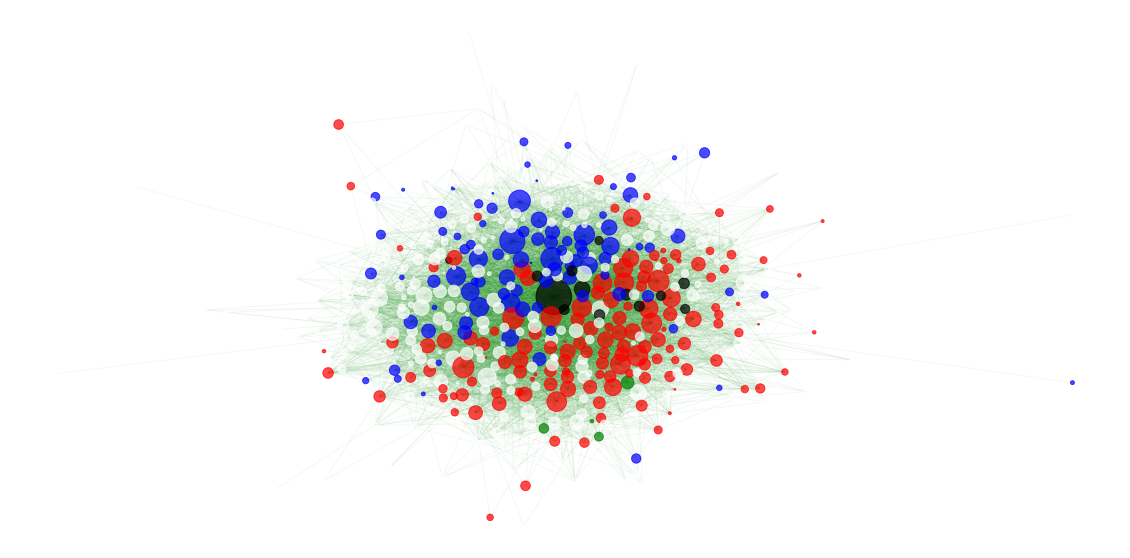

In [58]:
from fa2 import ForceAtlas2

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs   #Want hubs inside other!
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=True,
                        gravity=1.0,

                        # Log
                        verbose=True)


positions = forceatlas2.forceatlas2_networkx_layout(giant, pos=None, iterations=2000)

plt.figure(figsize=(20,10))
nx.draw_networkx_nodes(giant, positions, node_color=block_color_map, alpha=0.7,node_size=[v * 3 for v in d.values()])
nx.draw_networkx_edges(giant, positions, edge_color="green", alpha=0.05)
plt.axis('off')
plt.show()

Now we can observe some seperation between the red and blue blocs, with government entities in the middle (black nodes)

Let's try to eliminate the white ('UNKNOWNS')

In [59]:
for node in list(giant.nodes(data=True)):
    if (node[1]['block'] == 'white'):
        giant.remove_node(node[0])
block_color_map = list(nx.get_node_attributes(giant, 'block').values())
d = dict(giant.degree) #degrees for every node

print(block_color_map)

['red', 'red', 'red', 'red', 'red', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'red', 'red', 'red', 'blue', 'blue', 'red', 'black', 'red', 'blue', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'blue', 'blue', 'red', 'red', 'red', 'blue', 'blue', 'blue', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'blue', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'blue', 'blue', 'blue', 'red', 'blue', 'blue', 'blue', 'blue', 'blue', 'red', 'red', 'blue', 'blue', 'red', 'red', 'red', 'red', 'red', 'red', 'blue', 'red', 'black', 'black', 'blue', 'blue', 'red', 'blue', 'red', 'blue', 'red', 'blue', 'red', 'red', 'blue', 'red', 'red', 'blue', 'green', 'red', 'red', 'red', 'red', 'red', 'red', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'red', 'black', 'black', 'blue', 'blue', 'blue', 'red', 'red', 'blue', 'red', 'blue', 'red', 'red', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue'

100%|██████████| 2000/2000 [00:06<00:00, 312.76it/s]


BarnesHut Approximation  took  0.78  seconds
Repulsion forces  took  5.18  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.10  seconds
AdjustSpeedAndApplyForces step  took  0.21  seconds


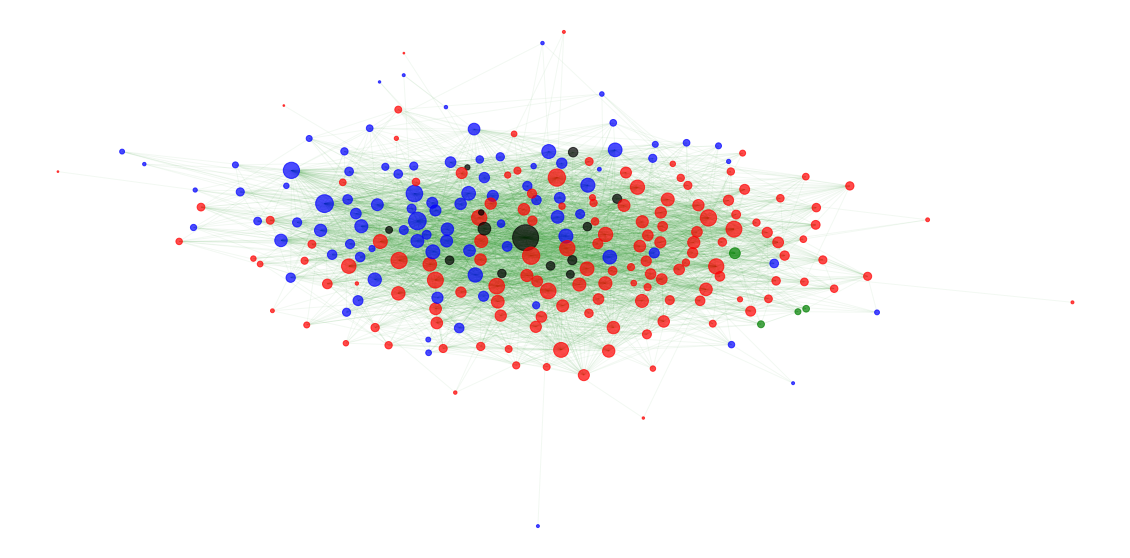

In [60]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs   #Want hubs inside other!
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=True,
                        gravity=1.0,

                        # Log
                        verbose=True)


positions = forceatlas2.forceatlas2_networkx_layout(giant, pos=None, iterations=2000)

plt.figure(figsize=(20,10))
nx.draw_networkx_nodes(giant, positions, node_color=block_color_map, alpha=0.7,node_size=[v * 3 for v in d.values()])
nx.draw_networkx_edges(giant, positions, edge_color="green", alpha=0.05)
plt.axis('off')
plt.show()

The network looks a bit neater, but we can observe that the large central government profiles have decreased in degree, signalling that a lot of the unknowns have tweeted to that profile. Interestingly, the few green block nodes are leaning to the right. Now we will look at sentiment of tweets, that link 2 profiles.

### Sentiment

In [61]:
#!pip install afinn
#!pip install langdetect

from langdetect import detect

#from textblob import TextBlob
from afinn import Afinn
afinn = Afinn()
afinn_da = Afinn(language='da')


        
print(afinn.score('Test bad bad booo hate'))
print(afinn.score('er'))

-9.0
0.0


In [62]:
with open('tweet_dict_listversion_wrealnames.data', 'rb') as filehandle:
    tweet_dict = pickle.load(filehandle) 
    



In [63]:
# helper function
def get_party(node):
    # returns party of a node
    x = data.loc[data['Twittername'] == node]    
    for w in x['Party']:
        return w
    #return x['Party'][0]



In [64]:
total_sentiment = dict.fromkeys(unique_parties)
for key, value in total_sentiment.items():
    total_sentiment[key] = { i : {'scores':[], 'mean': 0} for i in unique_parties }

total_sentiment

{'UNKNOWN': {'UNKNOWN': {'scores': [], 'mean': 0},
  'Radikale Venstre': {'scores': [], 'mean': 0},
  'Dansk Folkeparti': {'scores': [], 'mean': 0},
  'Government': {'scores': [], 'mean': 0},
  'Nye Borgerlige': {'scores': [], 'mean': 0},
  'Inuit Ataqatigiit': {'scores': [], 'mean': 0},
  'Venstre': {'scores': [], 'mean': 0},
  'Det Radikale Venstre': {'scores': [], 'mean': 0},
  'Enhedslisten': {'scores': [], 'mean': 0},
  'Det Konservative Folkeparti': {'scores': [], 'mean': 0},
  'Uden for folketingsgrupperne': {'scores': [], 'mean': 0},
  'Liberal Alliance': {'scores': [], 'mean': 0},
  'Socialdemokratiet': {'scores': [], 'mean': 0},
  'Socialistisk Folkeparti': {'scores': [], 'mean': 0},
  'Alternativet': {'scores': [], 'mean': 0}},
 'Radikale Venstre': {'UNKNOWN': {'scores': [], 'mean': 0},
  'Radikale Venstre': {'scores': [], 'mean': 0},
  'Dansk Folkeparti': {'scores': [], 'mean': 0},
  'Government': {'scores': [], 'mean': 0},
  'Nye Borgerlige': {'scores': [], 'mean': 0},
  '

In [65]:
# for each tweet calculate a score 
# get from party and to party
# update total
count = 0

for key,value in tqdm(tweet_dict.items()):
    #print(key)
    from_party = get_party(key)
    for mention, texts in value.items():
        to_party = get_party(mention)
        for tweet in texts:
            # remove @s
            tweet = re.sub(r'@\w+\b', '', tweet)
            tweet.strip()
            try:
                lang = detect(tweet)
            except Exception as e:
                print(e)
                print("tweet = " + tweet)
                continue # skip
            if lang == 'da' or lang == 'no':
                score = afinn_da.score(tweet)
            elif lang == 'en':
                score = afinn.score(tweet)
            else:
                score = 0
                print(tweet)
                print("Language    " + lang)
                print(" NOT IMPLEMENTED ")
                continue

            try:
                total_sentiment[from_party][to_party]['scores'].append(score)
            except Exception as e:
                print("Error" + str(e))
                print("Backlog: ")
                print("tweet from "  + key + " to " + mention)



   Men du fik din historie alligevel. Skam dig! https://t.co/cPD6ZmMAg9
Language    af
 NOT IMPLEMENTED 
   I know.
Language    pl
 NOT IMPLEMENTED 
  Enig
Language    de
 NOT IMPLEMENTED 
         Nej
Language    sk
 NOT IMPLEMENTED 
         Nej
Language    sk
 NOT IMPLEMENTED 
  Hurra 🙏🙏🙏
Language    es
 NOT IMPLEMENTED 
Mega god stil. Tak  https://t.co/AnQMDdi9xb
Language    sl
 NOT IMPLEMENTED 
  Tillykke
Language    fi
 NOT IMPLEMENTED 
 God bedring
Language    cy
 NOT IMPLEMENTED 
      Hvad mener du?
Language    nl
 NOT IMPLEMENTED 
      Hvad mener du?
Language    nl
 NOT IMPLEMENTED 
   Tak 
Language    id
 NOT IMPLEMENTED 
No features in text.
tweet =        👍
No features in text.
tweet =    🙏😊
No features in text.
tweet =    👊
No features in text.
tweet =    😂😂😂
No features in text.
tweet =   😂😂😂
    Puha 🤞
Language    id
 NOT IMPLEMENTED 
No features in text.
tweet =    👊
  Nemlig
Language    sv
 NOT IMPLEMENTED 
  Flot!
Language    sv
 NOT IMPLEMENTED 
No features in text

ErrorNone
Backlog: 
tweet from MetteGjerskov to MFVMin
ErrorNone
Backlog: 
tweet from MetteGjerskov to MFVMin
ErrorNone
Backlog: 
tweet from MetteGjerskov to MFVMin
ErrorNone
Backlog: 
tweet from MetteGjerskov to MFVMin
  Tak😀
Language    sw
 NOT IMPLEMENTED 
ErrorNone
Backlog: 
tweet from MetteGjerskov to Birgitte2012
   Ja.
Language    sw
 NOT IMPLEMENTED 
   Ja.
Language    sw
 NOT IMPLEMENTED 
    Nemlig!
Language    sv
 NOT IMPLEMENTED 
Stop DET STORE KUNSTTYVERI!
#dkpol #dkmedier ⁦⁩ ⁦⁩ ⁦⁩ ⁦⁩ https://t.co/qCI0V2Gq0x
Language    af
 NOT IMPLEMENTED 
Spot on, .
#dkpol #dkmedier
https://t.co/de5vUhIfZH
Language    af
 NOT IMPLEMENTED 
No features in text.
tweet =  😁🕺🏿
ErrorNone
Backlog: 
tweet from LotteRod to Birgitte2012
   Uddyb gerne
Language    cy
 NOT IMPLEMENTED 
   Uddyb gerne
Language    cy
 NOT IMPLEMENTED 
   Tak 👊
Language    id
 NOT IMPLEMENTED 
  Juhuu!! 💪🏼
Language    sw
 NOT IMPLEMENTED 
No features in text.
tweet =  https://t.co/5DN3xK6ub5
ErrorNone
Backlog: 
tweet f

ErrorNone
Backlog: 
tweet from MFVMin to MogensJensenS
ErrorNone
Backlog: 
tweet from MFVMin to MogensJensenS
ErrorNone
Backlog: 
tweet from MFVMin to MogensJensenS
ErrorNone
Backlog: 
tweet from MFVMin to MogensJensenS
ErrorNone
Backlog: 
tweet from MFVMin to MogensJensenS
ErrorNone
Backlog: 
tweet from MFVMin to MogensJensenS
ErrorNone
Backlog: 
tweet from MFVMin to MogensJensenS
ErrorNone
Backlog: 
tweet from MFVMin to MogensJensenS
ErrorNone
Backlog: 
tweet from MFVMin to MogensJensenS
ErrorNone
Backlog: 
tweet from MFVMin to MogensJensenS
ErrorNone
Backlog: 
tweet from MFVMin to MogensJensenS
ErrorNone
Backlog: 
tweet from MFVMin to MogensJensenS
ErrorNone
Backlog: 
tweet from MFVMin to MogensJensenS
ErrorNone
Backlog: 
tweet from MFVMin to MogensJensenS
ErrorNone
Backlog: 
tweet from MFVMin to MogensJensenS
ErrorNone
Backlog: 
tweet from MFVMin to MogensJensenS
ErrorNone
Backlog: 
tweet from MFVMin to MogensJensenS
ErrorNone
Backlog: 
tweet from MFVMin to MogensJensenS
ErrorNone


 God bedring!
Language    cy
 NOT IMPLEMENTED 
RT : Naturmødet online. Med Niels Hausgaard, Sebastian Klein, , Bonderøven, , partilederne, alt. De…
Language    nl
 NOT IMPLEMENTED 
ErrorNone
Backlog: 
tweet from LeaWermelin to MFVMin
ErrorNone
Backlog: 
tweet from LeaWermelin to MFVMin
ErrorNone
Backlog: 
tweet from LeaWermelin to MFVMin
ErrorNone
Backlog: 
tweet from LeaWermelin to MFVMin
ErrorNone
Backlog: 
tweet from LeaWermelin to MFVMin
ErrorNone
Backlog: 
tweet from LeaWermelin to MFVMin
ErrorNone
Backlog: 
tweet from LeaWermelin to MFVMin
ErrorNone
Backlog: 
tweet from LeaWermelin to MFVMin
ErrorNone
Backlog: 
tweet from LeaWermelin to MFVMin
ErrorNone
Backlog: 
tweet from LeaWermelin to MFVMin
ErrorNone
Backlog: 
tweet from LeaWermelin to MFVMin
ErrorNone
Backlog: 
tweet from LeaWermelin to MFVMin
ErrorNone
Backlog: 
tweet from LeaWermelin to MFVMin
ErrorNone
Backlog: 
tweet from LeaWermelin to MFVMin
ErrorNone
Backlog: 
tweet from LeaWermelin to MFVMin
RT : Tråd👇🏻 Cc: 
Languag

ErrorNone
Backlog: 
tweet from WeissPernille to AsgerChristens2
ErrorNone
Backlog: 
tweet from WeissPernille to AsgerChristens2
No features in text.
tweet =  💪🏻💚🙏🏻
 &lt;3
Language    hu
 NOT IMPLEMENTED 
 Tak ☺️☺️
Language    id
 NOT IMPLEMENTED 
    Tak til V ☺️
Language    et
 NOT IMPLEMENTED 
       Tak Henrik mv.
Language    et
 NOT IMPLEMENTED 
       Tak Henrik mv.
Language    et
 NOT IMPLEMENTED 
    Tak til V ☺️
Language    et
 NOT IMPLEMENTED 
       Tak Henrik mv.
Language    tr
 NOT IMPLEMENTED 
 Ingen årsag☺️
Language    sv
 NOT IMPLEMENTED 
       Tak Henrik mv.
Language    tr
 NOT IMPLEMENTED 
    Tak til V ☺️
Language    et
 NOT IMPLEMENTED 
   Sådan  👍😊
Language    sv
 NOT IMPLEMENTED 
RT : Tak  💪❤️ #dkpol
Language    id
 NOT IMPLEMENTED 
No features in text.
tweet =    ❤️
No features in text.
tweet =    ❤️
   Tak, Jacob!
Language    id
 NOT IMPLEMENTED 
   Tak, Jacob!
Language    id
 NOT IMPLEMENTED 
RT : Tak  💪❤️ #dkpol
Language    id
 NOT IMPLEMENTED 
ErrorNone
Backl

No features in text.
tweet =    😉👍 https://t.co/PWVzYlqbJf
No features in text.
tweet =    😉👍 https://t.co/PWVzYlqbJf
 Brånby, brånby, brånby
Language    sv
 NOT IMPLEMENTED 
No features in text.
tweet =     https://t.co/fboIssb5pd
   Tak, JC! 🙏🏼
Language    id
 NOT IMPLEMENTED 
No features in text.
tweet =     https://t.co/fboIssb5pd
   tak, fanny 🙏🏼🙏🏼
Language    hu
 NOT IMPLEMENTED 
   tak, johan!
Language    fi
 NOT IMPLEMENTED 
   tak, anders 🙏🏼
Language    af
 NOT IMPLEMENTED 
   tusind tak, birgitte!
Language    et
 NOT IMPLEMENTED 
   tak 👌🏻
Language    id
 NOT IMPLEMENTED 
   tak! 🙏🏼
Language    id
 NOT IMPLEMENTED 
   taaaak 🙏🏼
Language    so
 NOT IMPLEMENTED 
   tusind tak, randi 😊
Language    id
 NOT IMPLEMENTED 
   tusind tak! 🙏🏼
Language    et
 NOT IMPLEMENTED 
   tak 🙏🏼
Language    id
 NOT IMPLEMENTED 
No features in text.
tweet =        https://t.co/LIxm2j7bX6
        https://t.co/X3eqsAok0o
Jeps du kan se dem her
Language    id
 NOT IMPLEMENTED 
No features in text.
tw

   kl. 22.05
Language    et
 NOT IMPLEMENTED 
   Fordi?
Language    it
 NOT IMPLEMENTED 
   Nej.
Language    sk
 NOT IMPLEMENTED 
 God bedring
Language    cy
 NOT IMPLEMENTED 
 God bedring.
Language    cy
 NOT IMPLEMENTED 
 Respekt👍
Language    af
 NOT IMPLEMENTED 
 Tillykke
Language    fi
 NOT IMPLEMENTED 
  Så smukt!
Language    sv
 NOT IMPLEMENTED 
 LLR som STM....
Language    sv
 NOT IMPLEMENTED 
    Lige netop.
Language    af
 NOT IMPLEMENTED 
No features in text.
tweet =  https://t.co/XEhjTq2IPS
No features in text.
tweet =  https://t.co/xOSt3foda7
No features in text.
tweet =  https://t.co/VxUJ7cV3O5
Godaften, , har du tid til at svare nu? https://t.co/fMxXcZ4Mtn
Language    sv
 NOT IMPLEMENTED 
 Flot resultat Peter 👍🏻
Language    ca
 NOT IMPLEMENTED 
RT : https://t.co/QypkKQ7cPC
Med bl. a    og 
Language    cy
 NOT IMPLEMENTED 
RT : https://t.co/QypkKQ7cPC
Med bl. a    og 
Language    cy
 NOT IMPLEMENTED 
    Tak
Language    sw
 NOT IMPLEMENTED 
No features in text.
tweet =  📱🐢

ErrorNone
Backlog: 
tweet from AsgerChristens2 to NielsFuglsang
ErrorNone
Backlog: 
tweet from AsgerChristens2 to NielsFuglsang
ErrorNone
Backlog: 
tweet from AsgerChristens2 to NielsFuglsang
ErrorNone
Backlog: 
tweet from AsgerChristens2 to NielsFuglsang
ErrorNone
Backlog: 
tweet from AsgerChristens2 to NielsFuglsang
ErrorNone
Backlog: 
tweet from AsgerChristens2 to AnniMatthiesen
ErrorNone
Backlog: 
tweet from AsgerChristens2 to ErlingBonnesen
ErrorNone
Backlog: 
tweet from AsgerChristens2 to MogensJensenS
ErrorNone
Backlog: 
tweet from AsgerChristens2 to MogensJensenS
ErrorNone
Backlog: 
tweet from AsgerChristens2 to MogensJensenS
ErrorNone
Backlog: 
tweet from AsgerChristens2 to regeringDK
ErrorNone
Backlog: 
tweet from AsgerChristens2 to regeringDK
ErrorNone
Backlog: 
tweet from AsgerChristens2 to regeringDK
ErrorNone
Backlog: 
tweet from AsgerChristens2 to regeringDK
ErrorNone
Backlog: 
tweet from AsgerChristens2 to regeringDK
ErrorNone
Backlog: 
tweet from AsgerChristens2 to Sch

ErrorNone
Backlog: 
tweet from AndersKronborg to Birgitte2012
   Tak, Kurt!
Language    tr
 NOT IMPLEMENTED 
No features in text.
tweet =          https://t.co/IbuHh28zZh
   😀 Jep! 👍
Language    id
 NOT IMPLEMENTED 
    Præciiis
Language    ro
 NOT IMPLEMENTED 
    Præciiis
Language    ro
 NOT IMPLEMENTED 
     Præciiiis 🔥🔥🔥
Language    ro
 NOT IMPLEMENTED 
     Præciiiis 🔥🔥🔥
Language    ro
 NOT IMPLEMENTED 
No features in text.
tweet =         https://t.co/oXiAtaqyus
No features in text.
tweet =          🔥🤘💖
No features in text.
tweet =          🔥😎
No features in text.
tweet =         https://t.co/oXiAtaqyus
No features in text.
tweet =          🔥🤘💖
No features in text.
tweet =          🔥😎
No features in text.
tweet =         https://t.co/oXiAtaqyus
No features in text.
tweet =          🔥🤘💖
No features in text.
tweet =          🔥😎
No features in text.
tweet =         https://t.co/oXiAtaqyus
No features in text.
tweet =          🔥🤘💖
No features in text.
tweet =          🔥😎
No features 

RT : https://t.co/mjAsA07PbK #dkpol
Language    sl
 NOT IMPLEMENTED 
ErrorNone
Backlog: 
tweet from MereteDuePaarup to AsgerChristens2
RT :   Kina?
Language    sw
 NOT IMPLEMENTED 
RT : Godt i gang!       og Natasha Al-Hariri http…
Language    tl
 NOT IMPLEMENTED 
RT :   Kina?
Language    sw
 NOT IMPLEMENTED 
     Nemlig
Language    sv
 NOT IMPLEMENTED 
     Nemlig
Language    sv
 NOT IMPLEMENTED 
     Nemlig
Language    sv
 NOT IMPLEMENTED 
 Kanon
Language    tl
 NOT IMPLEMENTED 
  Do it!!! Og god tur.
Language    af
 NOT IMPLEMENTED 
#Fuckfingergate?
 
Language    de
 NOT IMPLEMENTED 
No features in text.
tweet =   https://t.co/KLa0GsgLHC
      Giv os data og du vil få svaret
Language    sv
 NOT IMPLEMENTED 
     Giv os data og vi vil svare
Language    sl
 NOT IMPLEMENTED 
      Giv os data og du vil få svaret
Language    sv
 NOT IMPLEMENTED 
     Giv os data og vi vil svare
Language    sl
 NOT IMPLEMENTED 
No features in text.
tweet =  https://t.co/JgKLqyyq3c
 Tak :)
Language    id


Mette på besøg hos Frau Merkel. Bild skriver mere om stole end om politik.    
Angela Merkel nach 3. Zitteranfall: Hymne im Sitzen auf Wunsch der Kanzlerin  https://t.co/XXL98hWBuu
Language    de
 NOT IMPLEMENTED 
  Plat kommentar, Jarlov
Language    sv
 NOT IMPLEMENTED 
 Klogt, Heidi
Language    de
 NOT IMPLEMENTED 
Bravo, virkelig godt  https://t.co/L4I9Pky83m
Language    sl
 NOT IMPLEMENTED 
 Enig!
Language    tl
 NOT IMPLEMENTED 
  Sejt gode  🙏🏻
Language    sq
 NOT IMPLEMENTED 
  Sejt gode  🙏🏻
Language    sq
 NOT IMPLEMENTED 
No features in text.
tweet = https://t.co/iYehuYQ3C8    
   Radikale drikker "Tullevand"🤗
Language    af
 NOT IMPLEMENTED 
RT : Stop klimahysteriet! #dkpol https://t.co/7idrKYOWw4
Language    af
 NOT IMPLEMENTED 
   Radikale drikker "Tullevand"🤗
Language    af
 NOT IMPLEMENTED 
   Radikale drikker "Tullevand"🤗
Language    af
 NOT IMPLEMENTED 
   Respekt Lars 👍🏿
Language    sv
 NOT IMPLEMENTED 
 Hep hep hurra 😳
Language    nl
 NOT IMPLEMENTED 
   Respekt Lars 👍

In [66]:
def isNaN(num):
    return num != num

In [67]:
for f, _to in total_sentiment.items():
    for key in _to.keys():
        mean = np.nanmean(total_sentiment[f][key]['scores'])
        if isNaN(mean):
            mean = 0
        total_sentiment[f][key]['mean'] = mean

C:\Users\Christian\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


In [68]:
for key, value in total_sentiment.items():
    sorted_list = sorted(value.items(), key=lambda k_v: k_v[1]['mean'])
    #print(sorted_list)
    sorted_list.reverse()
    print(key + " is most positive regarding " +  str(sorted_list[0][0]) + ":"+ str(sorted_list[0][1]['mean']))

UNKNOWN is most positive regarding Inuit Ataqatigiit:4.0
Radikale Venstre is most positive regarding Inuit Ataqatigiit:8.0
Dansk Folkeparti is most positive regarding Det Konservative Folkeparti:1.2678571428571428
Government is most positive regarding Socialistisk Folkeparti:1.6666666666666667
Nye Borgerlige is most positive regarding Venstre:1.3214285714285714
Inuit Ataqatigiit is most positive regarding Enhedslisten:3.5
Venstre is most positive regarding Radikale Venstre:2.019230769230769
Det Radikale Venstre is most positive regarding Alternativet:0
Enhedslisten is most positive regarding Dansk Folkeparti:1.0
Det Konservative Folkeparti is most positive regarding Venstre:1.564102564102564
Uden for folketingsgrupperne is most positive regarding Alternativet:3.0
Liberal Alliance is most positive regarding Radikale Venstre:1.4615384615384615
Socialdemokratiet is most positive regarding Det Radikale Venstre:3.0
Socialistisk Folkeparti is most positive regarding UNKNOWN:1.175609756097561